<a href="https://colab.research.google.com/github/Santhosh-12345/Detection-of-Heart-Murmur-from-Phonocardiogram-Signals/blob/main/PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import PatchTSTConfig, PatchTSTForClassification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchinfo import summary

In [ ]:
data_folder = "/content/drive/My Drive/Normalized2/Final/"
data_list, labels_list = [], []
# Load dataset
for file_name in os.listdir(data_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, header=0)
        df = df.select_dtypes(include=[np.number])  # Drop non-numeric columns
        if df.shape != (92, 52):
            print(f"Skipping {file_name} due to incorrect shape: {df.shape}")
            continue
        data_list.append(df.values)
        label = int(file_name.split("_")[-1].split(".")[0])  # Extract label
        labels_list.append(label)

# Convert to NumPy arrays
X = np.array(data_list)  # Shape: (num_samples, 92, 52)
y = np.array(labels_list)  # Shape: (num_samples,)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 52)).reshape(len(data_list), 92, 52)

# Split into train/test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Convert to PyTorch tensors
X_train, X_test = map(
    lambda x: torch.tensor(x, dtype=torch.float32), [X_train, X_test]
)
y_train, y_test = map(lambda y: torch.tensor(y, dtype=torch.long), [y_train, y_test])
# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = (
    X_train.to(device),
    X_test.to(device),
    y_train.to(device),
    y_test.to(device),
)


In [ ]:
config = PatchTSTConfig(
    num_input_channels=52,  # Features per timestep
    num_targets=2,  # Binary classification
    context_length=92,  # Sequence length
    patch_length=12,  # Adjust if needed
    stride=12,
     dropout=0.5,
    use_cls_token=True,
)

# Initialize PatchTST model
model = PatchTSTForClassification(config=config).to(device)

Epoch 1/60, Loss: 0.6621
Epoch 2/60, Loss: 0.6367
Epoch 3/60, Loss: 0.5949
Epoch 4/60, Loss: 0.5762
Epoch 5/60, Loss: 0.5707
Epoch 6/60, Loss: 0.5237
Epoch 7/60, Loss: 0.4999
Epoch 8/60, Loss: 0.4876
Epoch 9/60, Loss: 0.4696
Epoch 10/60, Loss: 0.4503
Epoch 11/60, Loss: 0.4310
Epoch 12/60, Loss: 0.4125
Epoch 13/60, Loss: 0.3414
Epoch 14/60, Loss: 0.3187
Epoch 15/60, Loss: 0.2648
Epoch 16/60, Loss: 0.2196
Epoch 17/60, Loss: 0.1957
Epoch 18/60, Loss: 0.1253
Epoch 19/60, Loss: 0.0792
Epoch 20/60, Loss: 0.0569
Epoch 21/60, Loss: 0.0409
Epoch 22/60, Loss: 0.0239
Epoch 23/60, Loss: 0.0171
Epoch 24/60, Loss: 0.0171
Epoch 25/60, Loss: 0.0117
Epoch 26/60, Loss: 0.0072
Epoch 27/60, Loss: 0.0059
Epoch 28/60, Loss: 0.0036
Epoch 29/60, Loss: 0.0033
Epoch 30/60, Loss: 0.0027
Epoch 31/60, Loss: 0.0022
Epoch 32/60, Loss: 0.0018
Epoch 33/60, Loss: 0.0017
Epoch 34/60, Loss: 0.0013
Epoch 35/60, Loss: 0.0012
Epoch 36/60, Loss: 0.0014
Epoch 37/60, Loss: 0.0011
Epoch 38/60, Loss: 0.0010
Epoch 39/60, Loss: 0.

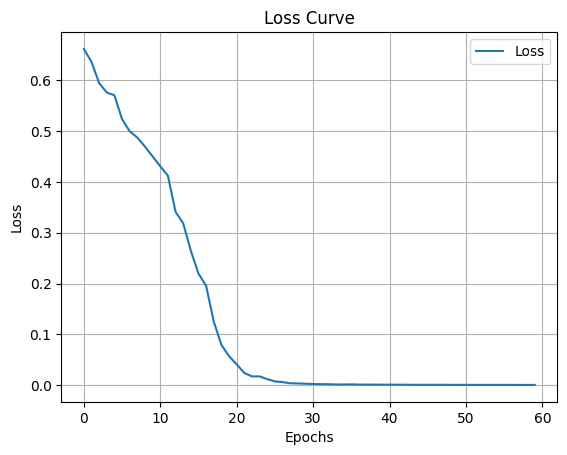

In [ ]:
batch_size = 16
train_loader = DataLoader(
    TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)  # Increase weight decay


# Training Loop
epochs = 60
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(past_values=X_batch).prediction_logits
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.8963

Classification Report:
              precision    recall  f1-score   support

      Absent       0.92      0.89      0.90        87
     Present       0.88      0.91      0.89        77

    accuracy                           0.90       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.90      0.90      0.90       164



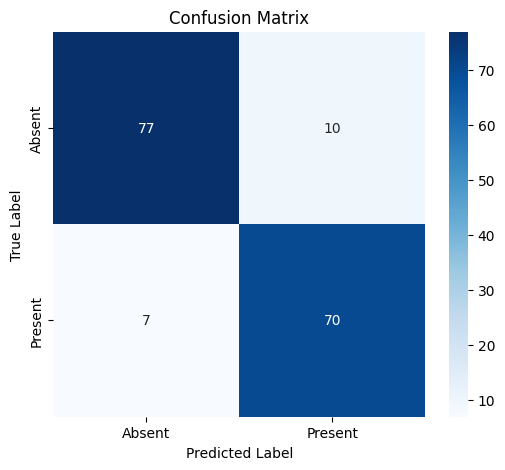

In [ ]:
model.eval()
X_full, y_full = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.long
).to(device)

with torch.no_grad():
    full_outputs = model(past_values=X_full).prediction_logits
    full_predictions = torch.argmax(full_outputs, dim=1)

y_full_cpu, full_predictions_cpu = y_full.cpu().numpy(), full_predictions.cpu().numpy()

# Compute accuracy
full_acc = accuracy_score(y_full_cpu, full_predictions_cpu)
print(f"Accuracy: {full_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_full_cpu, full_predictions_cpu, target_names=["Absent", "Present"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_full_cpu, full_predictions_cpu)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Absent", "Present"],
    yticklabels=["Absent", "Present"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print("Model Summary:\n")
summary(model, input_size=(16, 92, 52))  # Ensure batch size and dimensions match


Model Summary:



Layer (type:depth-idx)                                  Output Shape              Param #
PatchTSTForClassification                               [16, 2]                   --
├─PatchTSTModel: 1-1                                    [16, 52, 81, 12]          --
│    └─PatchTSTScaler: 2-1                              [16, 92, 52]              --
│    │    └─PatchTSTStdScaler: 3-1                      [16, 92, 52]              --
│    └─PatchTSTPatchify: 2-2                            [16, 52, 81, 12]          --
│    └─Identity: 2-3                                    [16, 52, 81, 12]          --
│    └─PatchTSTEncoder: 2-4                             [16, 52, 82, 128]         --
│    │    └─PatchTSTEmbedding: 3-2                      [16, 52, 81, 128]         1,664
│    │    └─PatchTSTPositionalEncoding: 3-3             [16, 52, 82, 128]         10,624
│    │    └─ModuleList: 3-4                             --                        594,816
├─PatchTSTClassificationHead: 1-2               